# Foundations of Linear Regression

In [12]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

## Exercise 1: Understanding the Likelihood of Observations Under a Given Gaussian Model 

### Question 1a: Gaussian Likelihood Function
Write a function to compute the likelihood of observing a set of values under a normal distribution with mean mu and variance sigma^2. The function should accept an observation Y, a mean value mu, and a standard deviation sigma, and return the likelihood of observing Y under these parameters.

In [13]:
def normal_pdf(y, mu, sigma):
    """Calculate the probability density of y under a Gaussian distribution with mean mu and standard deviation sigma."""
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((y - mu) ** 2) / (2 * sigma ** 2))

def normal_pdf(y, mu, sigma):
    return norm.pdf(y, mu, sigma)

### Question 1b: Likelihood Under Standard Normal Model
Simulate a sequence of values from -5 to 5 (with a step of 0.1) and calculate the likelihood of each value under a Standard Normal model (mu=0, sigma=1). Plot these likelihood values and discuss the shape of the plot.

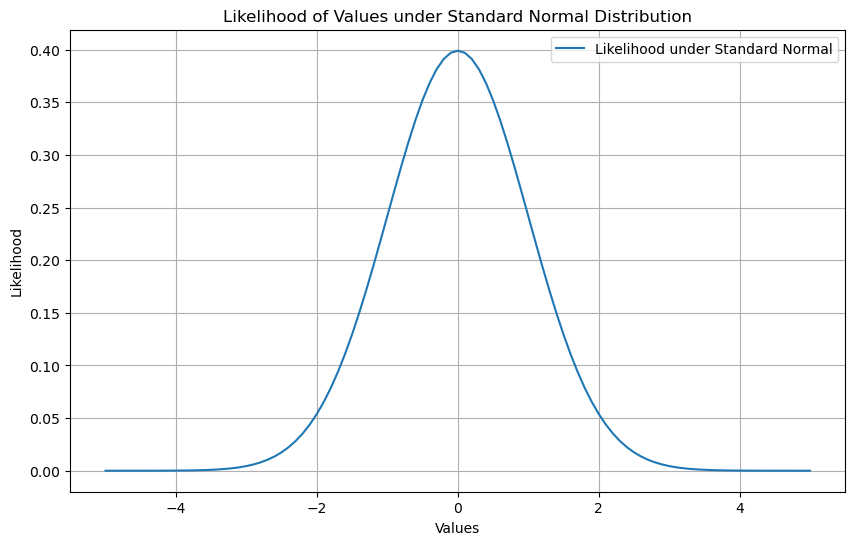

In [14]:
# Simulate a sequence of values from -5 to 5 with a step of 0.1
Y = np.arange(-5, 5.1, 0.1)

# Standard Normal parameters
mu = 0
sigma = 1

# Calculate the likelihood of each value under the Standard Normal model
likelihood_values = [normal_pdf(y, mu, sigma) for y in Y]

# Plot these likelihood values
plt.figure(figsize=(10, 6))
plt.plot(Y, likelihood_values, label='Likelihood under Standard Normal')
plt.title('Likelihood of Values under Standard Normal Distribution')
plt.xlabel('Values')
plt.ylabel('Likelihood')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 2: Playing with Linear Regression

We will work with the `Time-for-change` regression model to predict the results of the US elections. The goal of the model is to estimate the % of the two-party (Republican + Democrat) vote from 3 variables: the `incumbency` (i.e. whether the incumbent party candidate is seeking re-election or if it's a new candidate) of the president; the growth rate of the economy; and the approval rating of the incumbent party president. 

### Question 2a: Linear Regression Model
Estimate a linear regression model to predict vote share using at least one categorical variable (if applicable) and one numeric variable.

In [15]:
import os

# Change working directory to where you store the Camp files 
os.chdir('./ ')

In [16]:
import pandas as pd

# load Historical Election Results dataset
df = pd.read_csv('1976-2020-president.csv')

Here I want to include in this dataset the necessary tools to perform the `time for change` model. I need to augment the dataset with a) the `incumbency` of the party / president ; b) the real GDP growth in the year of the election; c) the `approval rating` of the incumbent president on the eve of the election. 

In [17]:
# Here we do a little data Wrangling to improve the dataset for analysis

# Focus on Democrats and Republicans only 
df = df[df['party_simplified'].str.contains('DEMOCRAT') | df['party_simplified'].str.contains('REPUBLICAN')]

# Calculate the two-party total votes for each state and year
df['two_party_total'] = df.groupby(['year', 'state'])['candidatevotes'].transform('sum')

# Calculate the percentage of the two-party vote afforded to each party
df['pct_2p_vote'] = 100*df['candidatevotes'] / df['two_party_total']

# define a function that returns the incumbent and whether the incumbent party is seeking their 2nd term in office
def identify_incumbent_complete(year):
    if year in [1976]:
        return ('REPUBLICAN', 0)  # Ford (Continuing Nixon's term)
    elif year in [1980]:
        return ('DEMOCRAT', 1)  # Carter
    elif year in [1984, 1988]:
        return ('REPUBLICAN', 1 if year == 1984 else 0)  # Reagan
    elif year in [1992]:
        return ('REPUBLICAN', 0)  # H.W. Bush (continuing Republican (Reagan) term)
    elif year in [1996, 2000]:
        return ('DEMOCRAT', 1 if year == 1996 else 0)  # Clinton
    elif year in [2004, 2008]:
        return ('REPUBLICAN', 1 if year == 2004 else 0)  # W. Bush
    elif year in [2012, 2016]:
        return ('DEMOCRAT', 1 if year == 2012 else 0)  # Obama
    elif year in [2020]:
        return ('REPUBLICAN', 1)  # Trump
    else:
        return ('None', 0)  # Default for years without a U.S. presidential election

# Apply the function to each row
df['incumbent_party'] = 'None'
df['term2'] = 0
for index, row in df.iterrows():
    incumbent_party, term2 = identify_incumbent_complete(row['year'])
    df.at[index, 'incumbent_party'] = incumbent_party
    df.at[index, 'term2'] = term2

# Now we can focus on the incumbent party, and focus our analysis to ask `what is the chance that the share of the vote the incmumbent will get ? 
df['incumbent_dummy'] = np.where(df['incumbent_party']==df['party_simplified'],1,0)
df = df[df['incumbent_dummy'] == 1]

# and we only need a few variables 
df = df[['year','state','pct_2p_vote','term2']]

In [18]:
# augment with national GDP data 
aux_gdp = pd.read_csv('Historical_National.US.GDP.csv')
aux_gdp = aux_gdp[aux_gdp['Items']=='Gross domestic product']

# melt 
aux_gdp = pd.melt(aux_gdp, id_vars='Items',var_name='year',value_name='real_gdp_pct_growth')
aux_gdp = aux_gdp[['year','real_gdp_pct_growth']]
aux_gdp['real_gdp_pct_growth'] = pd.to_numeric(aux_gdp['real_gdp_pct_growth'])

# merge with df 
df['year'] = df['year'].astype(int)  # Convert to int
aux_gdp['year'] = aux_gdp['year'].astype(int)  # Ensure this matches df
df = pd.merge(df, aux_gdp, on='year', how='left')

In [19]:
# augment with incumbent's approval rating
aux_app = pd.read_csv('Historical_President.Approval.Polls_Gallup.csv')
aux_app['net_approval'] = aux_app['Approving'] - aux_app['Disapproving']

# select only the approval polls right closest to the election
import pandas as pd

def last_approval_before_election(data):
    """
    Selects the last approval poll before each presidential election in the dataset.
    
    :param data: A pandas DataFrame with columns 'Start Date', 'End Date', 'Approving', 'Disapproving', 'Unsure/NoData', and 'net_approval'.
    :return: A pandas DataFrame with the selected polls.
    """
    # Convert date columns to datetime
    data['Start Date'] = pd.to_datetime(data['Start Date'])
    data['End Date'] = pd.to_datetime(data['End Date'])
    
    # Sort the data by 'End Date' to ensure chronological order
    data.sort_values(by='End Date', inplace=True)
    
    # Identify the range of years in the dataset
    start_year = data['End Date'].dt.year.min()
    end_year = data['End Date'].dt.year.max()
    
    # Presidential elections are held every 4 years, starting from 1944
    election_years = [year for year in range(start_year, end_year+1) if year % 4 == 0 and year >= 1944]
    
    selected_polls = []
    for year in election_years:
        # Election date: first Tuesday after the first Monday in November
        # Simplification: use November 1st as a base, then adjust
        base_date = pd.Timestamp(year=year, month=11, day=1)
        day_of_week = base_date.dayofweek
        election_date = base_date + pd.Timedelta(days=(1-day_of_week) % 7 + 1)
        
        # Select the last poll before the election
        last_poll = data[data['End Date'] < election_date].iloc[-1]
        selected_polls.append(last_poll)
    
    return pd.DataFrame(selected_polls)

# apply the function
aux_app = last_approval_before_election(aux_app)

# extract relevant year
aux_app['year'] = aux_app['End Date'].astype(str).str[:4].astype(int)

# drop unnecessary variables 
aux_app = aux_app[['year','net_approval']]

# merge with election results dataset 
df = pd.merge(df, aux_app, on='year', how='left')

In [20]:
# Let's see the results of our effors
print(df.to_string())

# Write this to a csv so we can use it in later workshops
df.to_csv('clean_TFC_data.csv', index=False)

     year                 state  pct_2p_vote  term2  real_gdp_pct_growth  net_approval
0    1976               ALABAMA    43.333276      0                  5.4             5
1    1976                ALASKA    61.891829      0                  5.4             5
2    1976               ARIZONA    58.613303      0                  5.4             5
3    1976              ARKANSAS    34.951149      0                  5.4             5
4    1976            CALIFORNIA    50.917827      0                  5.4             5
5    1976              COLORADO    55.907544      0                  5.4             5
6    1976           CONNECTICUT    52.610017      0                  5.4             5
7    1976              DELAWARE    47.269862      0                  5.4             5
8    1976  DISTRICT OF COLUMBIA    16.822278      0                  5.4             5
9    1976               FLORIDA    47.319798      0                  5.4             5
10   1976               GEORGIA    33.06170

### Now we estimate the `time for change` regression

In [21]:
import pandas as pd
import statsmodels.api as sm

# Define your design matrix and your target variable 

# Create dummy variables for 'state' column correctly
state_dummies = pd.get_dummies(df['state'], prefix='state', drop_first=True)

# Concatenate the dummy variables with the DataFrame
temp = pd.concat([df, state_dummies], axis=1)

# Specify the columns to be included in X. Ensure all are numeric
X = temp[['term2', 'real_gdp_pct_growth', 'net_approval'] + 
         state_dummies.columns.tolist()].astype(float) 
y = temp['pct_2p_vote']

# Add a constant to the features to account for the intercept in the model
X_with_const = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X_with_const).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            pct_2p_vote   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.146
Date:                Wed, 07 Feb 2024   Prob (F-statistic):              0.230
Time:                        14:50:46   Log-Likelihood:                -2330.6
No. Observations:                 614   AIC:                             4769.
Df Residuals:                     560   BIC:                             5008.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [22]:
new_data = {
    'const': 1.0,
    'term2': 1,  # Assuming it's the second term
    'real_gdp_pct_growth': 1.2,  # Adjust this according to your prediction
    'net_approval': -16.7,  # Adjust this according to your prediction
    # Add dummy variables for all states (0 or 1)
    'state_ALABAMA': 0,
    'state_ALASKA': 0,
    'state_ARIZONA': 0,
    'state_ARKANSAS': 0,
    'state_CALIFORNIA': 0,
    'state_COLORADO': 0,
    'state_CONNECTICUT': 0,
    'state_DELAWARE': 0,
    'state_FLORIDA': 0,
    'state_GEORGIA': 0,
    'state_HAWAII': 0,
    'state_IDAHO': 0,
    'state_ILLINOIS': 0,
    'state_INDIANA': 0,
    'state_IOWA': 0,
    'state_KANSAS': 0,
    'state_KENTUCKY': 0,
    'state_LOUISIANA': 0,
    'state_MAINE': 0,
    'state_MARYLAND': 0,
    'state_MASSACHUSETTS': 0,
    'state_MICHIGAN': 0,
    'state_MINNESOTA': 0,
    'state_MISSISSIPPI': 0,
    'state_MISSOURI': 0,
    'state_MONTANA': 0,
    'state_NEBRASKA': 0,
    'state_NEVADA': 0,
    'state_NEW_HAMPSHIRE': 0,
    'state_NEW_JERSEY': 0,
    'state_NEW_MEXICO': 0,
    'state_NEW_YORK': 0,
    'state_NORTH_CAROLINA': 0,
    'state_NORTH_DAKOTA': 0,
    'state_OHIO': 0,
    'state_OKLAHOMA': 0,
    'state_OREGON': 0,
    'state_PENNSYLVANIA': 0,
    'state_RHODE_ISLAND': 0,
    'state_SOUTH_CAROLINA': 0,
    'state_SOUTH_DAKOTA': 0,
    'state_TENNESSEE': 0,
    'state_TEXAS': 0,
    'state_UTAH': 0,
    'state_VERMONT': 0,
    'state_VIRGINIA': 0,
    'state_WASHINGTON': 0,
    'state_WEST_VIRGINIA': 0,
    'state_WISCONSIN': 0,
    'state_WYOMING': 1
}

# Convert the new data into a DataFrame
new_df = pd.DataFrame([new_data])

# Add a constant to the features to account for the intercept in the model

# Make predictions
predictions = model.predict(new_df)

# Print the predicted outcome
print("Predicted percentage of 2-party vote:", predictions[0])

Predicted percentage of 2-party vote: 50.60322390212683


### b) Inference by `Empirical Posterior` Simulations

Simulate 1000 values from the empirical posterior distribution of each of your coefficients. Plot the histogram for each of these coefficient simulations, and calculate: i. the proportion of simulation that are above 0; ii. the Monte Carlo Median and 95% prediction interval for each coefficient; iii. Comment on the significance and magnitude of the effects. 

### b) Inference by `Empirical Posterior` Simulations

Simulate 1000 values from the empirical posterior distribution of each of your coefficients. Plot the histogram for each of these coefficient simulations, and calculate: i. the proportion of simulation that are above 0; ii. the Monte Carlo Median and 95% prediction interval for each coefficient; iii. Comment on the significance and magnitude of the effects. 

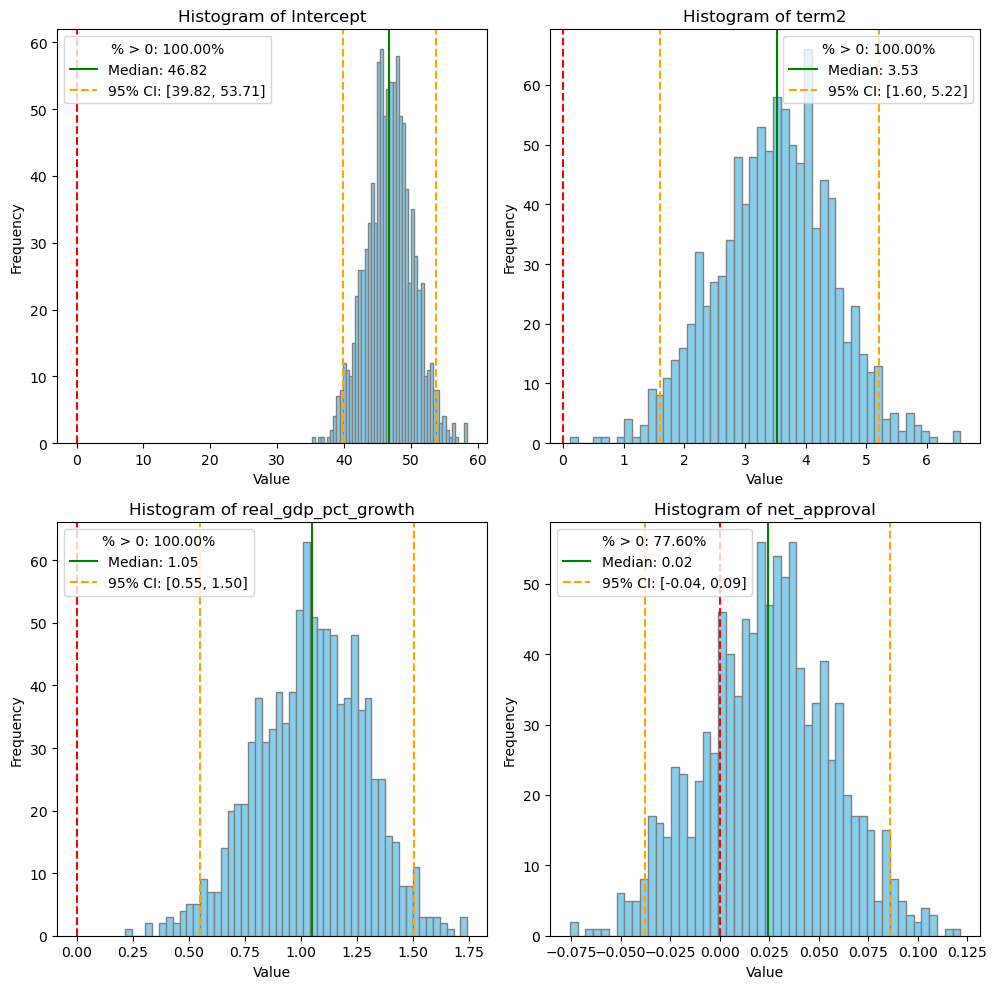

In [23]:
import matplotlib.pyplot as plt

# Simulate values from empirical posterior distribution of model coefficients
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), 1000)

# define param names 
parameter_names = ['Intercept','term2','real_gdp_pct_growth','net_approval']#model.params.index.tolist()
n_params = len(parameter_names)  # Number of parameters

# Adjust rows and columns for plotting
n_plots = n_params  # Total number of plots needed
n_rows = 2
n_cols = (n_plots + n_rows - 1) // n_rows  # Calculate columns needed, ensuring we have enough space

# Adjust the figsize if necessary
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5), squeeze=False)  # Make sure axes is always a 2D array

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

for i, name in enumerate(parameter_names):
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    confidence_interval = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes_flat[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


### c) Generate Predicted Values and Estimate Statistics

For each record in your dataset, generate predicted values. Use the package which you are using for fitting the regression model to output a) point estimates for each fitted value; b) the expected standard error of those estimates. Use these to generate 1000 samples from the empirical posterior distribution of the fitted values, and estimate the Monte Carlo Median and the 95% prediction interval.

In [24]:
import statsmodels.api as sm

# Step 1: Prepare the new dataset - remember to add a constant if your model includes an intercept
X_new = X
X_new_with_const = sm.add_constant(X_new) 

# Step 2: Predict new values
new_predictions = model.predict(X_new_with_const)

# Step 3: Calculate standard errors of the predictions
cov_matrix = model.cov_params()
design_matrix = X_new_with_const
variances = np.diag(np.dot(np.dot(design_matrix, cov_matrix), design_matrix.T))
std_errors_predictions = np.sqrt(variances)

# Generate posterior samples
new_predictions_array = np.array(new_predictions)[:, None]  # Convert to numpy array and add new axis
std_errors_predictions_array = np.array(std_errors_predictions)[:, None]  # Convert to numpy array and add new axis

predicted_samples = np.random.normal(loc=new_predictions_array,
                                     scale=std_errors_predictions_array,
                                     size=(new_predictions.shape[0], 1000))

monte_carlo_medians = np.median(predicted_samples, axis=1)
prediction_intervals = np.percentile(predicted_samples, [2.5, 97.5], axis=1)


### d) Plot Observed vs. Predicted Values with Prediction Intervals

Plot the observed values (on the y-axis) against the Monte Carlo Median of the fitted values (x-axis) for each observation. On the same plot, find a way to add the prediction intervals around your fitted values. Make sure the y and x axis span the same support, and add a y = x line to the plot. Comment on what the plot shows - does your model recover good predictions ? How can you tell ? Play around with your model and look how including / removing complexity changes the performance. 

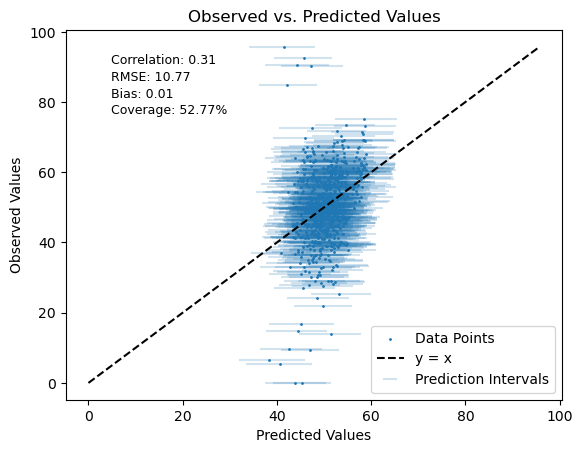

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y)[0, 1]
rmse = np.sqrt(mean_squared_error(y, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y)  # Mean prediction error
coverage = np.mean((y >= prediction_intervals[0,:]) & (y <= prediction_intervals[1,:]))

# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_samples_flat = predicted_samples.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_samples_flat, y])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()
